In [141]:
import numpy as np
import matplotlib.pyplot as plt
import typing
%matplotlib inline

Text(0, 0.5, '1/x')

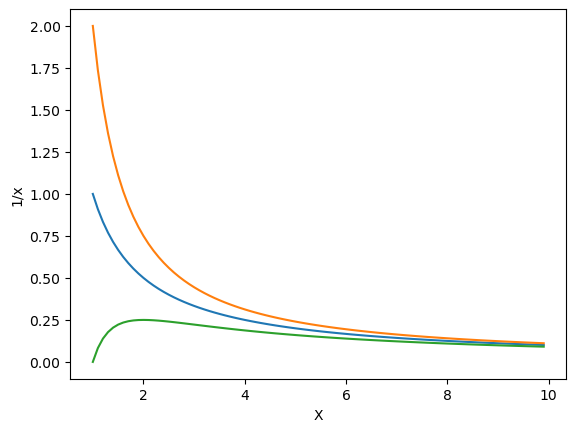

In [13]:
# naive IB approach

T = typing.TypeVar("T")


class IBVariable:
    value: float
    uncert: float

    def __init__(self, value: float, uncert: float = 0.0):
        self.value = value
        self.uncert = uncert

    @staticmethod
    def from_abs(value: float, uncert: float):
        return IBVariable(value, uncert)

    @staticmethod
    def from_rel(value: float, uncert: float):
        return IBVariable(value, uncert * value)

    def __repr__(self) -> str:
        return f"IBVariable(value={self.value}, uncert={self.uncert})"

    def __str__(self) -> str:
        return f"({self.value} +- {self.uncert})"

    def abs(self):
        return self.uncert

    def rel(self):
        return self.uncert / self.value

    def __add__(self, other):
        if isinstance(other, IBVariable):
            return IBVariable(self.value + other.value, self.uncert + other.uncert)
        elif isinstance(other, float | int):
            return IBVariable(self.value + other, self.uncert)

        raise Exception(f"unknown type {type(other)}")

    def __radd__(self, other):
        return self.__add__(other)

    def __neg__(self):
        return IBVariable(-self.value, self.uncert)

    def __sub__(self, other):
        return self + -other

    def __rsub__(self, other):
        return -self + other

    def __mul__(self, other):
        if isinstance(other, IBVariable):
            return IBVariable.from_rel(
                self.value * other.value, self.rel() + other.rel()
            )
        elif isinstance(other, float | int):
            return IBVariable.from_rel(self.value * other, self.rel())

        raise Exception(f"unknown type {type(other)}")

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        if isinstance(other, IBVariable):
            return IBVariable.from_rel(
                self.value / other.value, self.rel() + other.rel()
            )
        elif isinstance(other, float | int):
            return IBVariable.from_rel(self.value / other, self.rel())

        raise Exception(f"unknown type {type(other)}")

    def __rtruediv__(self, other):
        if isinstance(other, IBVariable):
            return IBVariable.from_rel(
                other.value / self.value, self.rel() + other.rel()
            )
        elif isinstance(other, float | int):
            return IBVariable.from_rel(other / self.value, self.rel())

        raise Exception(f"unknown type {type(other)}")

    def __pow__(self, other):
        if isinstance(other, int | float):
            return IBVariable.from_rel(self.value**other, abs(other * self.rel()))

        raise Exception(f"unknown type {type(other)}")


# x = IBVariable(10.0, 0.1)
# print(x / 2)
xs = np.arange(1.0, 10, 0.1)
ys = []
yupper = []
ylower = []
for i in xs:
    var = IBVariable(float(i), 1.0)
    var = 1.0 / var
    value = var.value
    ys.append(value)
    yupper.append(var.abs() + value)
    ylower.append(-var.abs() + value)

plt.plot(xs, ys)
plt.plot(xs, yupper)
plt.plot(xs, ylower)
plt.xlabel("X")
plt.ylabel("1/x")

In [ ]:
# partial implementation





0.510528339254817
0.2677408690220966


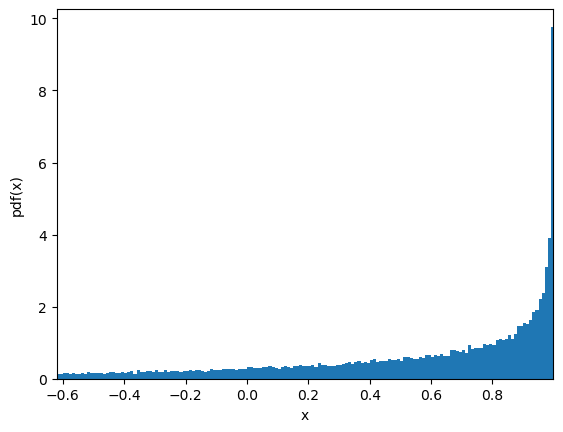

In [145]:
# monte-carlo sampling method
import random
import operator
from scipy import stats as st


class MonteCarloVariable:
    is_pure: bool
    dependencies: list["MonteCarloVariable"]
    operation: typing.Optional[typing.Callable]

    icdf: typing.Optional[typing.Callable[[float], float]]

    REUSE_SAMPLES: bool = True
    samples: list[float]

    def __init__(self, dependencies: list["MonteCarloVariable"], operation, icdf):
        if icdf is None:
            self.is_pure = False
            self.dependencies = dependencies
            self.operation = operation
            self.icdf = None
        else:
            self.is_pure = True
            self.dependencies = []
            self.operation = None
            self.icdf = icdf

        self.samples = []

    @staticmethod
    def from_operation(op, dependencies):
        return MonteCarloVariable(dependencies, op, None)

    @staticmethod
    def from_pure(icdf):
        return MonteCarloVariable([], None, icdf)

    @staticmethod
    def from_constant(value: float):
        def icdf(x):
            return value

        return MonteCarloVariable([], None, icdf)

    @staticmethod
    def from_normal(mean: float = 0.0, sd: float = 1.0):
        def icdf(x):
            return st.norm.ppf(x, loc=mean, scale=sd)

        return MonteCarloVariable([], None, icdf)

    def sample(self, percent: typing.Optional[float] = None) -> float:
        if self.is_pure:
            return self.icdf(random.random() if percent is None else percent)

        values = [dep.sample() for dep in self.dependencies]
        return self.operation(*values)

    def simulate(self, amount: int):
        if self.REUSE_SAMPLES and len(self.samples) > 0:
            return self.samples

        self.samples = [self.sample() for _ in range(amount)]
        return self.samples

    def mean(self, amount: int = 1000):
        return np.mean(self.simulate(amount))

    def var(self, amount: int = 1000):
        return np.var(self.simulate(amount), ddof=1)

    def graph(
        self, lower: float = 0.001, upper: float = 1 - 0.001, step: float = 0.0001
    ):
        if not self.is_pure:
            raise Exception("variable not pure")

        percents = np.arange(lower, upper, step)
        values = [self.sample(x) for x in percents]

        heights = []
        for i in range(1, len(values) - 1):
            der = (step * 2) / (values[i + 1] - values[i - 1])
            heights.append(der)

        plt.plot(values[1:-1], heights)
        plt.show()

    def simulate_graph(
        self, lower: float = None, upper: float = None, amount: int = 1000, width = 0.1
    ):
        xs = self.simulate(amount)

        plt.hist(xs, density=True, bins=np.arange(min(xs), max(xs) + width, width))

        if lower is None:
            lower = np.quantile(xs, 0.05)
        if upper is None:
            upper = np.quantile(xs, 0.95)

        plt.xlim([lower, upper])
        plt.xlabel("x")
        plt.ylabel("pdf(x)")
        plt.show()

    ### OVERLOADS ###
    def __add__(self, other):
        if isinstance(other, MonteCarloVariable):
            return MonteCarloVariable.from_operation(operator.add, [self, other])
        elif isinstance(other, float | int):
            const = MonteCarloVariable.from_constant(other)
            return MonteCarloVariable.from_operation(operator.add, [self, const])

        raise Exception("unknown operand type")

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        if isinstance(other, MonteCarloVariable):
            return MonteCarloVariable.from_operation(operator.mul, [self, other])
        elif isinstance(other, float | int):
            const = MonteCarloVariable.from_constant(other)
            return MonteCarloVariable.from_operation(operator.mul, [self, const])

        raise Exception("unknown operand type")

    def __rmul__(self, other):
        return self * other

    def __neg__(self):
        return MonteCarloVariable.from_operation(operator.neg, [self])

    def __sub__(self, other):
        return self + -other

    def __rsub__(self, other):
        return -self + other

    def __pow__(self, other):
        if isinstance(other, MonteCarloVariable):
            return MonteCarloVariable.from_operation(operator.pow, [self, other])
        elif isinstance(other, float | int):
            const = MonteCarloVariable.from_constant(other)
            return MonteCarloVariable.from_operation(operator.pow, [self, const])

        raise Exception("unknown operand type")

    def __truediv__(self, other):
        if isinstance(other, MonteCarloVariable):
            return MonteCarloVariable.from_operation(operator.truediv, [self, other])
        elif isinstance(other, float | int):
            const = MonteCarloVariable.from_constant(other)
            return MonteCarloVariable.from_operation(operator.truediv, [self, const])

        raise Exception("unknown operand type")

    def __rtruediv__(self, other):
        if isinstance(other, MonteCarloVariable):
            return MonteCarloVariable.from_operation(operator.truediv, [other, self])
        elif isinstance(other, float | int):
            const = MonteCarloVariable.from_constant(other)
            return MonteCarloVariable.from_operation(operator.truediv, [const, self])

        raise Exception("unknown operand type")

    def apply(self, operation):
        return MonteCarloVariable.from_operation(operation, [self])


# x = MonteCarloVariable.from_normal(10, 0.01)
# y = MonteCarloVariable.from_normal(5, 0.05)

# expr = x * y
# expr.simulate(50000)
# print(expr.var() ** 0.5)
# print(np.sqrt((0.01/10)**2 + (0.05/5)**2)*50)

x = MonteCarloVariable.from_normal(1, 1)
expr = x.apply(np.sin)

expr.simulate(50000)
print(expr.mean())
print(expr.var())
expr.simulate_graph(width=0.01)